# Cleaning of Raw Images (Digitalization)

input: radars.yaml + aemet images (do we combine for 1 feature or not)
output: Object of each image at certain time - make it possible to combine images of the same time

## Classes
Radar --> each radar from radars.yaml file --> ignore the metadata and use it as a comment
RadarCollection --> contains all the Radar objects from that radars.yaml file

PreprocessedImage -->
Image that contain its radar information that has been
It should have Radar Assoicated with the location

PreprocessedImageMixed -->
take in multiple ProcessedImage from different location but at the same time
It should be a inherited item from PreprocessedImage

PreprocessedImageCollection --> collection containing all the preprocessed image.


In [ ]:
from typing import Dict, List, Tuple
from PIL import Image
from datetime import datetime
import glob
from pathlib import Path
import numpy as np

In [166]:
def rgb2hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b).lower()

In [147]:
class AemetColorScheme:
    def __init__(self,
                 color_hexes_set):
        self.color_hexes_set = color_hexes_set

    @classmethod
    def from_cropped_image(cls,
                           img: Image):
        img = img.convert('RGB')
        imgarray = np.array(img)
        color_hexes_set = set()
        print(img.size)
        for x in range(img.width):
            for y in range(img.height):
                r, g, b = imgarray[y, x]
                color_hexes_set.add(rgb2hex(r, g, b))
        return AemetColorScheme(color_hexes_set)

    @classmethod
    def from_file_path(cls,
                       file_path: str):
        img = Image.open(file_path)
        return cls.from_cropped_image(img)

In [173]:



class Radar:

    def __init__(self,
                 rdr_code: str,
                 latitude: float,
                 longitude: float,
                 radius: int,
                 name: str):
        self.rdr_code = rdr_code
        self.latitude = latitude
        self.longitude = longitude
        self.radius = radius
        self.name = name

    @classmethod
    def from_radar_dict(cls, radar_dict: Dict) -> 'Radar':
        """
        rdr_code: 'cc'
        latitude: 39.428820
        longitude: -6.285380
        radius: 240
        name: 'Cáceres'
        TODO: maybe moved the dict keys as class variables
        :param radar_dict:
        :return:
        """
        return Radar(
            rdr_code=radar_dict['rdr_code'],
            latitude=radar_dict['latitude'],
            longitude=radar_dict['longitude'],
            radius=radar_dict['radius'],
            name=radar_dict['name']
        )


class RadarCollection:
    YAML_FILE_DATA_KEY = 'data'
    YAML_FILE_METADATA_KEY = 'metadata'

    def __init__(self,
                 radars: List[Radar],
                 meta_data_dict: Dict):
        """
        TODO: maybe leave transform metadata into class
        :param radars:
        :param meta_data_dict:
        """
        self.radars = radars
        self.meta_data_dict = meta_data_dict

    def to_dict(self) -> Dict[str, Radar]:  # list out radar code to radar
        """
        :return:
        """
        return {x.rdr_code: x for x in self.radars}

    @classmethod
    def from_file_path(cls, path: str) -> 'RadarCollection':
        with open(path, 'r') as stream:
            data_loaded = yaml.safe_load(stream)
            lst_radar = []
            for radar_key in data_loaded[RadarCollection.YAML_FILE_DATA_KEY].keys():
                radar_dict = data_loaded[RadarCollection.YAML_FILE_DATA_KEY][radar_key]
                radar = Radar.from_radar_dict(radar_dict)
                lst_radar.append(radar)
            return RadarCollection(
                radars=lst_radar,
                meta_data_dict=data_loaded[RadarCollection.YAML_FILE_METADATA_KEY]
            )


class PreprocessedImage:
    mask_color_hexes = {"#0000fc","#0094fc","#00fcfc","#ffff00","#ffbb00","#fe7e01","#ff0000","#c8065a","#00e200"}

    def __init__(self,
                 file_path: str,
                 image_taken_at: datetime,
                 radar: Radar):
        self.file_path = file_path
        self.image_taken_at = image_taken_at
        self.radar = radar
        # we dont load these initially to save space
        self.initial_mask = None  # phase 1 input
        self.interference_removed_mask = None  # phase 1 output. phase 2 input?
        self.reconstruction_mask = None  # final output
        self.aemet_color_scheme = None  # we can auto detect this

    def set_aemet_color_scheme(self,
                               aemet_color_scheme: AemetColorScheme):
        self.aemet_color_scheme = aemet_color_scheme

    def set_initial_mask(self,
                         initial_mask):
        self.initial_mask = initial_mask

    def set_interference_removed_mask(self,
                                      interference_removed_mask):
        self.interference_removed_mask = interference_removed_mask

    def set_reconstruction_mask(self,
                                reconstruction_mask):
        self.reconstruction_mask = reconstruction_mask

    def _load_image(self) -> Image:
        return Image.open(self.file_path)

    def _generate_circle_mask(self,
                              h,
                              w) -> np.array:
        # implementation based on
        # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
        # TODO: center and radius need to be checked
        center = (int(w / 2), int(h / 2))
        radius = self.radar.radius
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
        mask = dist_from_center <= radius
        return mask

    def _mask_out_of_circle(self,
                            img: Image) -> np.array:
        img = img.convert("RGB")
        imgarray = np.array(img)
        mask = self._generate_circle_mask(img.height, img.width)
        imgarray[~mask, :] = 0
        return imgarray

    def _mask_out_none_reflection_color(self,
                                        img: Image) -> np.array:
        # if self.aemet_color_scheme is None:
        #     self._generate_aemet_color_scheme()
        img = img.convert("RGB")
        imgarray = np.array(img)
        # there has to be a way better way to do this than a double loop with numpy
        for x in range(img.width):
            for y in range(img.height):
                r, g, b = imgarray[x, y]
                hex = rgb2hex(r, g, b)
                if hex not in PreprocessedImage.mask_color_hexes:
                    imgarray[x, y, :] = 255
        return imgarray

    def _generate_aemet_color_scheme(self):
        """
        TODO: auto detect aemet color scheme in image and assign
        :return:
        """
        img = self._load_image()
        img = img.convert("RGB")
        # 26, 371, 37, 478
        cropped_img = img.crop((26, 371, 37, 478))
        cropped_img.show()
        self.set_aemet_color_scheme(AemetColorScheme.from_cropped_image(cropped_img))

    def generate_initial_mask(self):
        """
        this assume that the image is in aemet format
        :return:
        """
        raw_img = self._load_image()
        raw_img.show()
        cropped_img = raw_img.crop((0, 0, self.radar.radius * 2, self.radar.radius * 2))
        masked_non_reflective_array = self._mask_out_none_reflection_color(cropped_img)
        masked_non_reflective_img = Image.fromarray(masked_non_reflective_array, 'RGB')
        masked_non_reflective_img.show()
        initial_mask_array = self._mask_out_of_circle(masked_non_reflective_img)
        initial_mask = Image.fromarray(initial_mask_array, 'RGB')
        initial_mask.show()
        raw_img.close()
        cropped_img.close()
        masked_non_reflective_img.close()
        return initial_mask

    def __str__(self):
        return self.file_path

    def __hash__(self):
        return hash(self.file_path)

    def __eq__(self, other):
        if not isinstance(other, type(self)): return NotImplemented
        return self.file_path == other.file_path

    def __lt__(self, other):
        if not isinstance(other, type(self)): return NotImplemented
        return self.file_path < other.file_path

    def __gt__(self, other):
        if not isinstance(other, type(self)): return NotImplemented
        return self.file_path > other.file_path

    @staticmethod
    def parse_file(file_name: str) -> Tuple[str, str]:
        """
        parse base file name to get radar code name and datetime string  from file name
        maybe use regex instead
        :param file_name:
        :return:
        """
        file_name = os.path.basename(file_name)  # might not work for windows system
        path_obj = Path(file_name)
        extensions = "".join(path_obj.suffixes)
        just_file_name = str(path_obj).replace(extensions, "")
        splitted = just_file_name.split('_')
        if len(splitted) != 3:
            raise Exception('{} is not parsable'.format(just_file_name))
        return splitted[1], splitted[2]

    @classmethod
    def from_file_path_and_radar_collection(cls,
                                            file_path: str,
                                            radar_collection: RadarCollection):
        """
        Given Image and Radar, correctly process it in such a way that u can get a mask up
        :param file_path:
        :param radar_collection:
        :return:
        """
        radar_code, datetime_str = PreprocessedImage.parse_file(file_path)
        radar_dict = radar_collection.to_dict()
        if radar_code not in radar_dict.keys():
            raise Exception("{} radar code is not in radars.yaml".format(radar_code))
        radar = radar_dict[radar_code]
        image_taken_at = datetime.strptime(datetime_str, "%Y%m%d%H%M")
        return PreprocessedImage(
            file_path=file_path,
            image_taken_at=image_taken_at,
            radar=radar
        )


class PreprocessedImageCollection:
    """
    may need to contain the metadata information but i havent think about how yet or what variables to introduce
    """

    def __init__(self,
                 preprocessed_images: List[PreprocessedImage]):
        self.preprocessed_images = preprocessed_images

    def size(self):
        return len(self.preprocessed_images)

    def set_aemet_color_scheme_to_all_images(self,
                                             aemet_color_scheme: AemetColorScheme):
        for pi in self.preprocessed_images:
            pi.set_aemet_color_scheme(aemet_color_scheme)

    def get_image(self, index: int):
        return self.preprocessed_images[index]

    def add_another_collection(self,
                               collection: 'PreprocessedImageCollection') -> 'PreprocessedImageCollection':
        """
        add without overlap
        :param collection:
        :return:
        """
        return PreprocessedImageCollection(
            list(set(self.preprocessed_images).union(set(collection.preprocessed_images))))

    def filter_based_on_radar_code(self,
                                   radar_code: str) -> 'PreprocessedImageCollection':

        images = [pi for pi in self.preprocessed_images if pi.radar.rdr_code == radar_code]
        return PreprocessedImageCollection(images)

    def filter_based_on_before_and_after_datetime(self,
                                                  before_dt: datetime,
                                                  after_dt: datetime) -> 'PreprocessedImageCollection':
        images = [pi for pi in self.preprocessed_images if after_dt <= pi.image_taken_at <= before_dt]
        return PreprocessedImageCollection(images)

    def filter_based_on_radar_code_and_time(self,
                                            radar_code: str,
                                            before_dt: datetime,
                                            after_dt: datetime) -> 'PreprocessedImageCollection':
        pic = self.filter_based_on_radar_code(radar_code)
        pic = pic.filter_based_on_before_and_after_datetime(before_dt=before_dt,
                                                            after_dt=after_dt)
        return pic

    @classmethod
    def from_radar_collection_and_aemet_folders_path(cls,
                                                     radar_collection: RadarCollection,
                                                     aemet_folders_path: str) -> 'PreprocessedImageCollection':
        """
        simply get all files --> file name should be in format {aemet}_{location}_{date_time_taken}.gif
        :param radar_collection:
        :param aemet_folders_path:
        :return:
        """
        all_gif_files = glob.glob(aemet_folders_path + '/**/*.gif', recursive=True)
        preprocessed_images = []
        for fname in all_gif_files:
            try:
                preprocessed_images.append(PreprocessedImage.from_file_path_and_radar_collection(file_path=fname,
                                                                                                 radar_collection=radar_collection))
            except Exception as e:
                # TODO: figure out if we need to solve this or print as a check is enough
                print(e)
        return PreprocessedImageCollection(sorted(preprocessed_images))


# not needed because u can just use file name
def get_subdirectory_name_in_directory(d_name: str) -> List[str]:
    return sorted([name for name in os.listdir(d_name) if os.path.isdir(os.path.join(*[d_name, name]))])


class PreprocessedImageMixed(PreprocessedImage):
    @classmethod
    def from_preprocessed_images(self) -> 'PreprocessedImageMixed':
        pass

In [133]:
import os
import yaml

data_path = os.path.join(os.path.dirname(os.path.realpath(os.getcwd())), 'data')
aemet_folders_path = os.path.join(*[data_path, 'aemet', '10min'])
radar_path = os.path.join(data_path, 'radars.yaml')
aemet_color_scheme_path = os.path.join(data_path, 'aemet_color_scheme.png')




In [ ]:
rc = RadarCollection.from_file_path(radar_path)

In [174]:
pic = PreprocessedImageCollection.from_radar_collection_and_aemet_folders_path(rc, aemet_folders_path)
# pic.set_aemet_color_scheme_to_all_images(aemet_color_scheme)

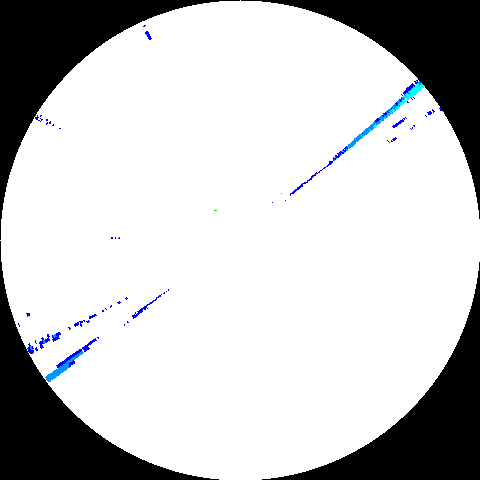

In [175]:
pic.get_image(0).generate_initial_mask()

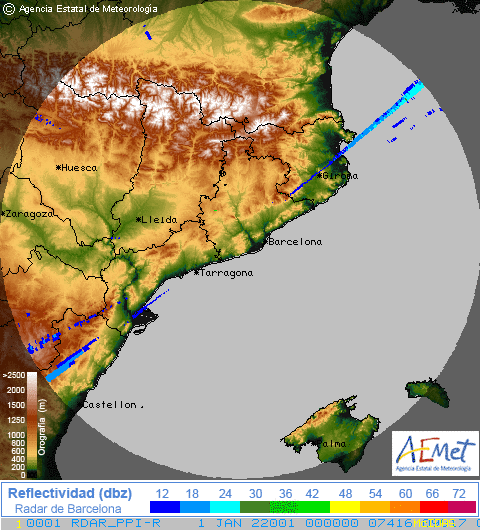

In [146]:
Image.open(pic.get_image(0).file_path).crop()

# 26, 371, 37, 478

In [118]:
pic.get_image(0).file_path

'/Users/wit/DataspellProjects/winter_school_hackathon/data/aemet/10min/pm/20220228/aemet_pm_202202282340.gif'

In [ ]:
# #0404CD #0000FC #0000F2 #73F8FA #43661C  #66DE42 #66DE42 #FFFF54 #F5BE41
# #73F8FA #73F8FA
# color code 72, 36, 60 all are weird in some pic
# #D02D37
# 66 #D02D37
# weird 60 orange #F5BE41 #EE8532
# weird 36 greeens #538133 #54A22F

In [68]:


raw_img = pic.get_image(0)._load_image()

# # left, upper, right, and lower
# # get the cropped image
# cropped_img = raw_img.crop(0, 0, self.radar.radius, self.radar.radius)
#
# # mask the out of circle
#
# # mask
#
# raw_img.close()

AttributeError: 'PreprocessedImage' object has no attribute '_load_image'